In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# 
# Query the date column of the Measurement table, then order by date descending, then limit the 
# output to one record:
dates = session.query(Measurement, Measurement.date).order_by(Measurement.date.desc()).limit(1).all()

# Returns a list with a tuple in it, containing the object and the date:
# [(<sqlalchemy.ext.automap.measurement object at 0x7fe5490bf0a0>, '2017-08-23')]
# print(dates)

# Returns a tuple with an object and the date:
# (<sqlalchemy.ext.automap.measurement object at 0x7fe5490bf0a0>, '2017-08-23')
# print(dates[0])

# Returns just the date
# 2017-08-23
date = dates[0][1]
print(date)

# Could have also done this by using 'scalar' instead fo 'all':
# date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).scalar()
# print(date)

2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# 
# This approach uses date passed as a string from above.  However, the rubric says not to do that, 
# so it's reimplemented as a sql query in the cell below.  Keeping this for reference ... 
# 
'''
# Convert the date into year, month, and day, while also stripping leading zeros from month and day:
date_list = date.split("-")
# date_list
year=date_list[0]
month=date_list[1].lstrip('0')
day=date_list[2].lstrip('0')
# print(year)
# print(month)
# print(day)

# Calculate the date one year from the last date in data set.
# 
# Convert year, month and day to integers for dt.time and take the delta:
year_ago = dt.date(int(year), int(month), int(day)) - dt.timedelta(days=365)
# print(year_ago)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()
'''

'\n# Convert the date into year, month, and day, while also stripping leading zeros from month and day:\ndate_list = date.split("-")\n# date_list\nyear=date_list[0]\nmonth=date_list[1].lstrip(\'0\')\nday=date_list[2].lstrip(\'0\')\n# print(year)\n# print(month)\n# print(day)\n\n# Calculate the date one year from the last date in data set.\n# \n# Convert year, month and day to integers for dt.time and take the delta:\nyear_ago = dt.date(int(year), int(month), int(day)) - dt.timedelta(days=365)\n# print(year_ago)\n\n# Perform a query to retrieve the data and precipitation scores\nprecip = session.query(Measurement.date, Measurement.prcp).    filter(Measurement.date > year_ago).    order_by(Measurement.date).all()\n'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# 
# Alternate way to do the query that doesn't require one to pass in the date string.  
# However, `subquery` is also a variable and some may consider that to be passing the 
# date in as a variable, so it's reimplemented below without use of any variable.  
# 
'''
subquery = session.query(func.date(func.datetime(Measurement.date, '-365 days')))\
    .order_by(Measurement.date.desc()).limit(1).scalar()
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > (subquery))\
        .order_by(Measurement.date).all()
'''

"\nsubquery = session.query(func.date(func.datetime(Measurement.date, '-365 days')))    .order_by(Measurement.date.desc()).limit(1).scalar()\nprecip = session.query(Measurement.date, Measurement.prcp).    filter(Measurement.date > (subquery))        .order_by(Measurement.date).all()\n"

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# 
# This query uses a subquery to get the most recent date in the table and subtract 365 days 
# from that date.  Then it uses a filter to return all rows more recent than that date.  
# 
# Returns a list of tuples, like this:
# [('2016-08-24', 0.08), ('2016-08-24', 2.15), ('2016-08-24', 2.28), ('2016-08-24', None), ...
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(
        Measurement.date > (
            session.query(func.date(func.datetime(Measurement.date, '-365 days')))\
            .order_by(Measurement.date.desc()).limit(1).scalar()
        ) 
    )\
    .order_by(Measurement.date).all()
# print(precip)

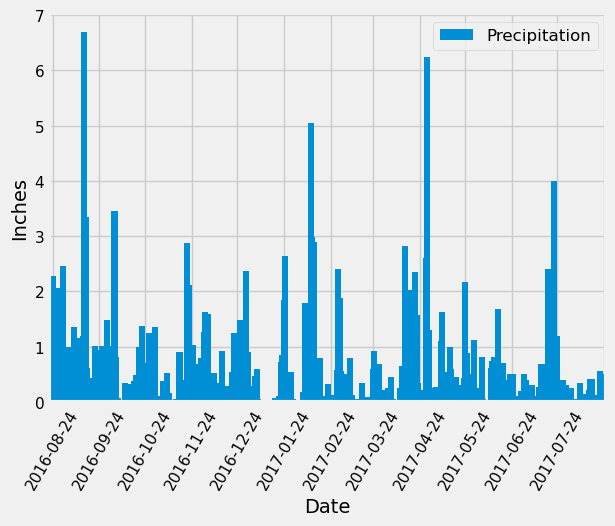

In [22]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip, columns = ['Date', 'Precipitation']).set_index('Date')
precip_df

# Sort the dataframe by date
precip_df = precip_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
# 
# Example shows aggregation of max temperatures, so let's aggregate by max temperature for each date:
plot_df = precip_df.groupby('Date').max()

plot_df.plot(kind="bar", width=4, fontsize=11)
plt.ylabel("Inches", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.xticks([0,31,61,92,122,153,184,212,243,273,304,334,365],rotation=60)
plt.legend(loc='upper right', prop={'size': 12})
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.station).count()
print(f" There are {station_count} stations in the dataset.")

 There are 9 stations in the dataset.


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

# Validate whether the station column can be used for our join:
# session.query(Measurement.station, Station.station).limit(100).all()

stations = session.query(Measurement.station, Station.name, func.count(Measurement.tobs))\
    .join(Station, Station.station == Measurement.station)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.tobs).desc()).all()

# Iterate over stations to show the count of observations for each station
for station, name, count in stations:
    print(f"Station: {station}, Name: {name}, Observations Count: {count}")

Station: USC00519281, Name: WAIHEE 837.5, HI US, Observations Count: 2772
Station: USC00519397, Name: WAIKIKI 717.2, HI US, Observations Count: 2724
Station: USC00513117, Name: KANEOHE 838.1, HI US, Observations Count: 2709
Station: USC00519523, Name: WAIMANALO EXPERIMENTAL FARM, HI US, Observations Count: 2669
Station: USC00516128, Name: MANOA LYON ARBO 785.2, HI US, Observations Count: 2612
Station: USC00514830, Name: KUALOA RANCH HEADQUARTERS 886.9, HI US, Observations Count: 2202
Station: USC00511918, Name: HONOLULU OBSERVATORY 702.2, HI US, Observations Count: 1979
Station: USC00517948, Name: PEARL CITY, HI US, Observations Count: 1372
Station: USC00518838, Name: UPPER WAHIAWA 874.3, HI US, Observations Count: 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and 
# average temperature.

# Get the station with the most observations:
# 
# `stations` returns: 
# [('USC00519281', 'WAIHEE 837.5, HI US', 2772),
#  ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
# ...
# It's a list, so let's take the first item:
# `stations[0]` returns: 
# ('USC00519281', 'WAIHEE 837.5, HI US', 2772)
# It's a tuple, so let's take the first item:
top_station = stations[0][0]

# Query to get the min, max and average temperature observations for the top station:
measurements = session.query(
    Measurement.station, \
        func.min(Measurement.tobs),\
        func.max(Measurement.tobs), 
        func.avg(Measurement.tobs))\
    .filter(Measurement.station == top_station).all()
# print(measurements)

for station, min, max, average in measurements:
    print(f"Station: {station}, Minimum Temp: {min}, Maximum Temp: {max}, Average Temp: {average}")

Station: USC00519281, Minimum Temp: 54.0, Maximum Temp: 85.0, Average Temp: 71.66378066378067


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as 
# a histogram

# Query to get the previous year's starting date, so we can have 1 year of measurements:
previous_year = session.query(func.date(func.datetime(Measurement.date, '-365 days')))\
    .order_by(Measurement.date.desc()).limit(1).scalar()
# Query to get dates and temperature measurements for all available dates in the final 12 months of our data set:
temps = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.date > (previous_year))\
    .filter(Measurement.station == top_station)\
    .order_by(Measurement.date).all()
print(temps)

[('2016-08-24', 77.0), ('2016-08-25', 80.0), ('2016-08-26', 80.0), ('2016-08-27', 75.0), ('2016-08-28', 73.0), ('2016-08-29', 78.0), ('2016-08-30', 77.0), ('2016-08-31', 78.0), ('2016-09-01', 80.0), ('2016-09-02', 80.0), ('2016-09-03', 78.0), ('2016-09-04', 78.0), ('2016-09-05', 78.0), ('2016-09-06', 73.0), ('2016-09-07', 74.0), ('2016-09-08', 80.0), ('2016-09-09', 79.0), ('2016-09-10', 77.0), ('2016-09-11', 80.0), ('2016-09-12', 76.0), ('2016-09-13', 79.0), ('2016-09-14', 75.0), ('2016-09-15', 79.0), ('2016-09-16', 78.0), ('2016-09-17', 79.0), ('2016-09-18', 78.0), ('2016-09-19', 78.0), ('2016-09-20', 76.0), ('2016-09-21', 74.0), ('2016-09-22', 77.0), ('2016-09-23', 78.0), ('2016-09-24', 79.0), ('2016-09-25', 79.0), ('2016-09-26', 77.0), ('2016-09-27', 80.0), ('2016-09-28', 78.0), ('2016-09-29', 78.0), ('2016-09-30', 78.0), ('2016-10-01', 77.0), ('2016-10-02', 79.0), ('2016-10-03', 79.0), ('2016-10-04', 79.0), ('2016-10-05', 79.0), ('2016-10-06', 75.0), ('2016-10-07', 76.0), ('2016-10

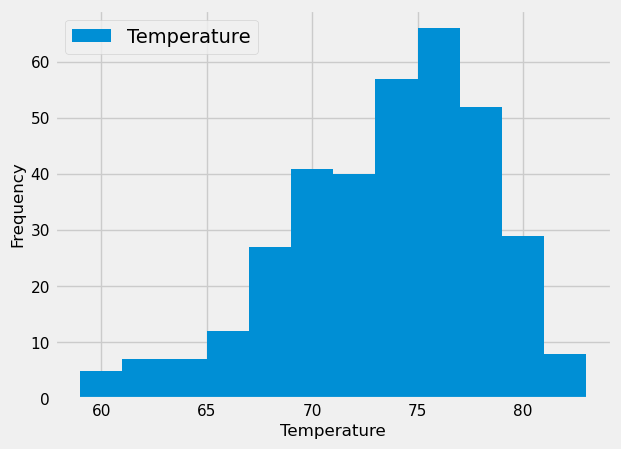

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column
temps_df = pd.DataFrame(temps, columns = ['Date', 'Temperature']).set_index('Date')
temps_df

# Sort the dataframe by date
temps_df = temps_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
# 
# Group the measurements by max temperature for each date:
temps_df = temps_df.groupby('Date').max()
# temps_df

temps_df.plot(kind="hist", bins=12, fontsize=11)
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

# Close session

In [221]:
# Close Session
session.close()